# Using Machine Learning to predict solubility of solutes in polymers

Data source: Predicting the solubility of gases, vapors, and supercritical fluids in amorphous polymers from electron density using convolutional neural networks. URL: https://doi.org/10.1039/D3PY01028G

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

import os

RANDOM_SEED = 1

## Data Exploration

In [4]:
# Print all files in the ../data directory
data_dir = "../data"
if os.path.exists(data_dir):
    files = os.listdir(data_dir)
    print(f"Files in {data_dir}:")
    for file in files:
        print(f" - {file}")
else:
    print(f"Directory {data_dir} does not exist")

Files in ../data:
 - experimental_dataset.csv
 - list_of_polymers.csv
 - list_of_solvents.csv
 - polymers.txt
 - polymer_mass.csv
 - solvents.txt
 - solvent_macro_features.csv
 - solvent_mass.csv
 - test_pairs.csv
 - val_pairs.csv


In [5]:
df_exp = pd.read_csv("../data/experimental_dataset.csv")
df_pinfo = pd.read_csv("../data/list_of_polymers.csv")
df_sinfo = pd.read_csv("../data/list_of_solvents.csv")

Joining databases:

In [6]:
df_merge1 = pd.merge(left = df_pinfo, right = df_exp, left_on = "polymer", right_on = "polymer", how = "left")
df_full = pd.merge(left = df_sinfo, right = df_merge1, left_on = "solvent", right_on = "solvent", how = "left")

In [7]:
# Create a new column with all possible combinations
df_full["sol-pol"] = df_full["polymer"].astype(str) + " - " + df_full["solvent"].astype(str)

# Count the number of unique elements in the combined column
n_unique_SolPol = df_full["sol-pol"].nunique()
print(n_unique_SolPol)

515


Compare columns before and after merging:

In [8]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15966 entries, 0 to 15965
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   solvent      15966 non-null  int64  
 1   formula      15966 non-null  object 
 2   name_x       15966 non-null  object 
 3   stype        15966 non-null  object 
 4   polymer      15964 non-null  float64
 5   abr          15964 non-null  object 
 6   name_y       12759 non-null  object 
 7   ptype        15964 non-null  object 
 8   expno        15964 non-null  float64
 9   mn           15964 non-null  float64
 10  mw           15964 non-null  float64
 11  cryst        15964 non-null  float64
 12  tg           15964 non-null  float64
 13  dens         15964 non-null  float64
 14  pressure     15964 non-null  float64
 15  temperature  15964 non-null  float64
 16  wa           15964 non-null  float64
 17  doi          15964 non-null  object 
 18  notes        15925 non-null  object 
 19  sol-

In [9]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15966 entries, 0 to 15965
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   solvent      15966 non-null  int64  
 1   formula      15966 non-null  object 
 2   name_x       15966 non-null  object 
 3   stype        15966 non-null  object 
 4   polymer      15964 non-null  float64
 5   abr          15964 non-null  object 
 6   name_y       12759 non-null  object 
 7   ptype        15964 non-null  object 
 8   expno        15964 non-null  float64
 9   mn           15964 non-null  float64
 10  mw           15964 non-null  float64
 11  cryst        15964 non-null  float64
 12  tg           15964 non-null  float64
 13  dens         15964 non-null  float64
 14  pressure     15964 non-null  float64
 15  temperature  15964 non-null  float64
 16  wa           15964 non-null  float64
 17  doi          15964 non-null  object 
 18  notes        15925 non-null  object 
 19  sol-

Exploring the distribution in each column:

array([[<Axes: title={'center': 'solvent'}>,
        <Axes: title={'center': 'polymer'}>,
        <Axes: title={'center': 'expno'}>],
       [<Axes: title={'center': 'mn'}>, <Axes: title={'center': 'mw'}>,
        <Axes: title={'center': 'cryst'}>],
       [<Axes: title={'center': 'tg'}>, <Axes: title={'center': 'dens'}>,
        <Axes: title={'center': 'pressure'}>],
       [<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'wa'}>, <Axes: >]], dtype=object)

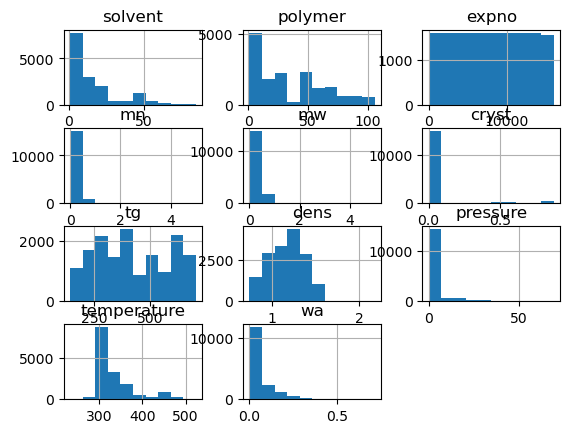

In [10]:
df_full.hist()

In [11]:
df_full.head()

,solvent,formula,name_x,stype,polymer,abr,name_y,ptype,expno,mn,mw,cryst,tg,dens,pressure,temperature,wa,doi,notes,sol-pol
0,1,CO2,carbon dioxide,OX,1.0,Matrimid,"5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...",PI,29.0,18000.0,80000.0,0.0,611.0,1.225,0.096330,296.15,0.024814,10.1016/S0376-7388(02)00385-X,Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...,1.0 - 1
1,1,CO2,carbon dioxide,OX,1.0,Matrimid,"5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...",PI,30.0,18000.0,80000.0,0.0,611.0,1.225,0.444954,296.15,0.048406,10.1016/S0376-7388(02)00385-X,Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...,1.0 - 1
2,1,CO2,carbon dioxide,OX,1.0,Matrimid,"5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...",PI,31.0,18000.0,80000.0,0.0,611.0,1.225,0.779817,296.15,0.061171,10.1016/S0376-7388(02)00385-X,Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...,1.0 - 1
3,1,CO2,carbon dioxide,OX,1.0,Matrimid,"5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...",PI,32.0,18000.0,80000.0,0.0,611.0,1.225,1.133028,296.15,0.070268,10.1016/S0376-7388(02)00385-X,Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...,1.0 - 1
4,1,CO2,carbon dioxide,OX,1.0,Matrimid,"5(6)- amino-1-(4'-aminophenyl)-1,3,-trimethyli...",PI,33.0,18000.0,80000.0,0.0,611.0,1.225,1.477064,296.15,0.077454,10.1016/S0376-7388(02)00385-X,Matrimid; INCOMPLETE CHARACTERIZATION WARNING;...,1.0 - 1


In [12]:
# Rename
df_full.rename(columns = {'formula': 'sol',
                       'abr': 'pol'}, inplace = True)

df_full['sol'] = df_full['sol'].astype('category')
df_full['pol'] = df_full['pol'].astype('category')

In [13]:
print("Unique solvents:", df_full['sol'].unique())

print()
print("Unique polymers:", df_full['pol'].unique())


Unique solvents: ['CO2', 'CH4', 'C4H10', 'CClF2CH3', 'CF3CH2F', ..., 'C4H8O2', 'C2H5COC2H5', 'C3H7OC3H7', 'CH3NO2', '(C2H3)OCOCH3']
Length: 73
Categories (73, object): ['(C2H3)OCOCH3', 'Ar', 'C2F6', 'C2H2', ..., 'PO(CH3)(OCH3)2', 'SF6', 'SO2', 'Xe']

Unique polymers: ['Matrimid', 'PCL', 'PE', 'PEG', 'PET', ..., 'PEV', 'P4VP', 'PVME', '6FDA-5CMPD', '6FDA-44DDM']
Length: 106
Categories (105, object): ['6FDA-34DPE', '6FDA-44DDM', '6FDA-4`4-DPE', '6FDA-5CMPD', ..., 'TMPSF', 'mPBI', 'poly(2-EAdMA)', 'poly(2-MAdMA)']


Limit prediction to CO2 only:

In [14]:
df_co2=df_full.loc[df_full["sol"] == "CO2"]

In [15]:
df_co2['sol'].unique()

['CO2']
Categories (73, object): ['(C2H3)OCOCH3', 'Ar', 'C2F6', 'C2H2', ..., 'PO(CH3)(OCH3)2', 'SF6', 'SO2', 'Xe']

# Data exploration

## Visualise our Feature / Target Relationship

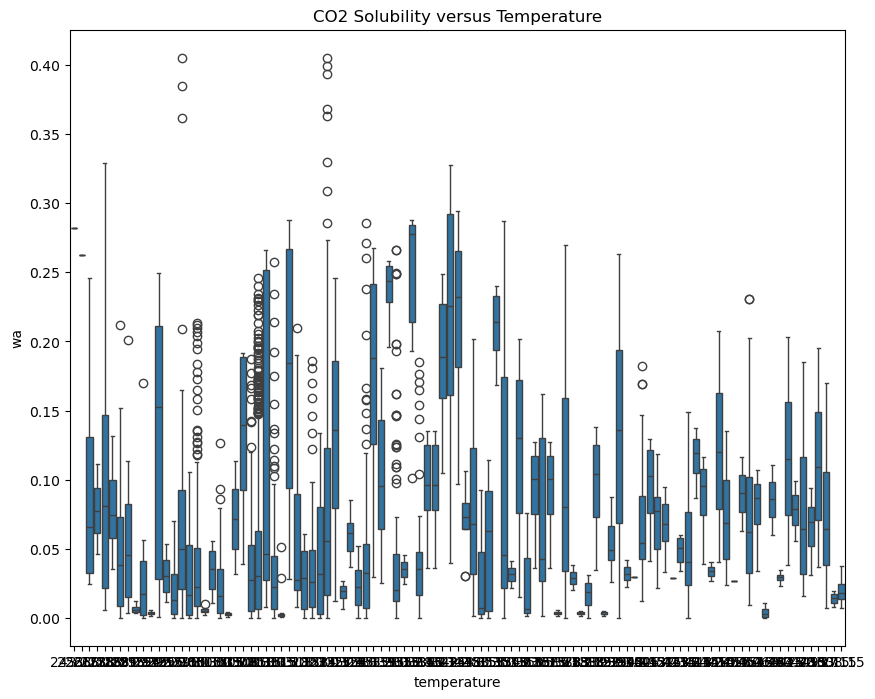

In [17]:
# Temperature
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='temperature', y='wa')
ax.set_title('CO2 Solubility versus Temperature')
plt.show()

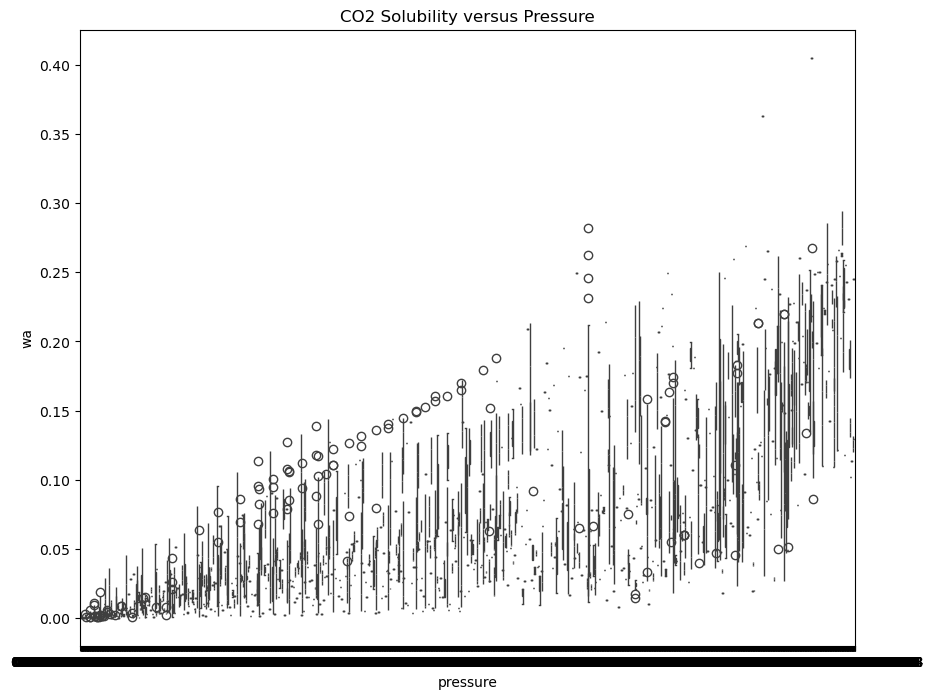

In [18]:
# Pressure
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='pressure', y='wa')
ax.set_title('CO2 Solubility versus Pressure')
plt.show()

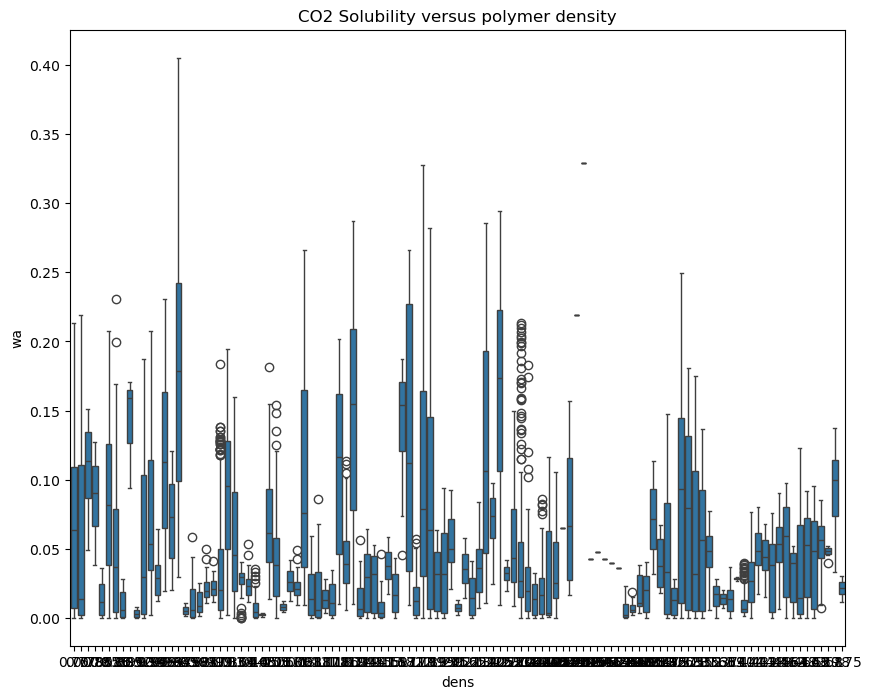

In [19]:
# Density
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='dens', y='wa')
ax.set_title('CO2 Solubility versus polymer density')
plt.show()

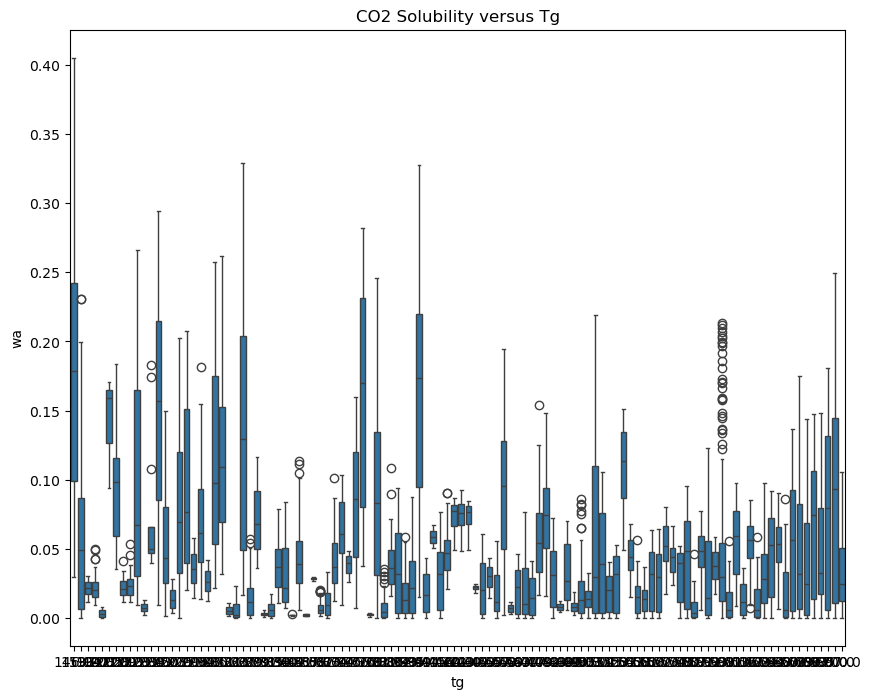

In [20]:
# Tg
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='tg', y='wa')
ax.set_title('CO2 Solubility versus Tg')
plt.show()

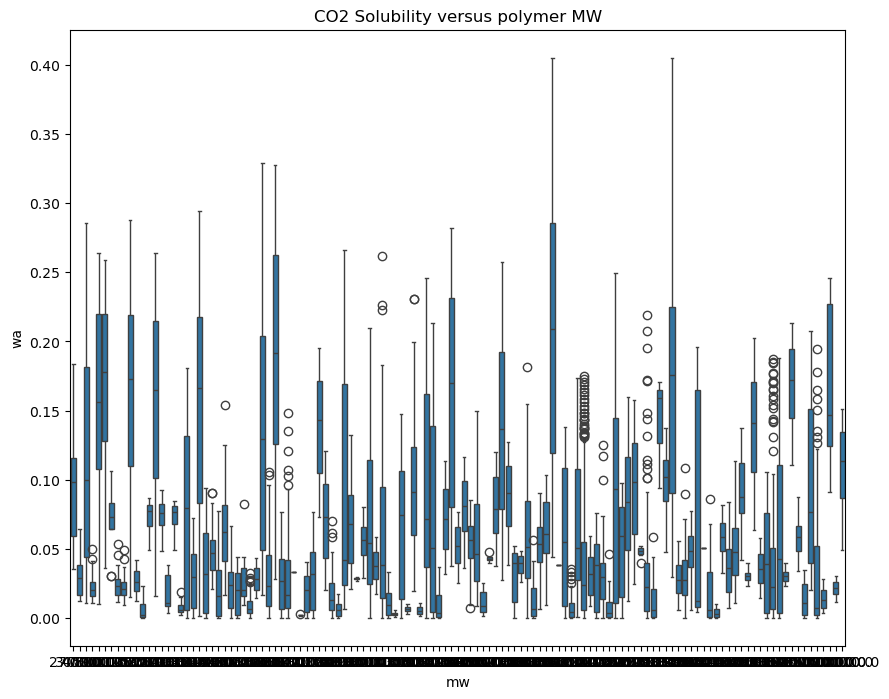

In [21]:
# Pressure
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='mw', y='wa')
ax.set_title('CO2 Solubility versus polymer MW')
plt.show()

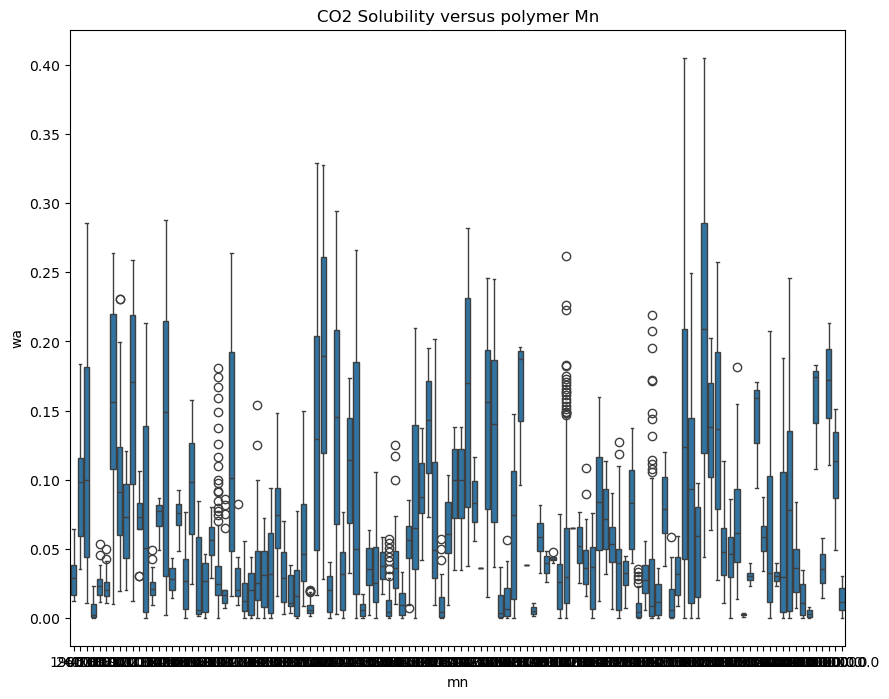

In [22]:
# mn
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='mn', y='wa')
ax.set_title('CO2 Solubility versus polymer Mn')
plt.show()

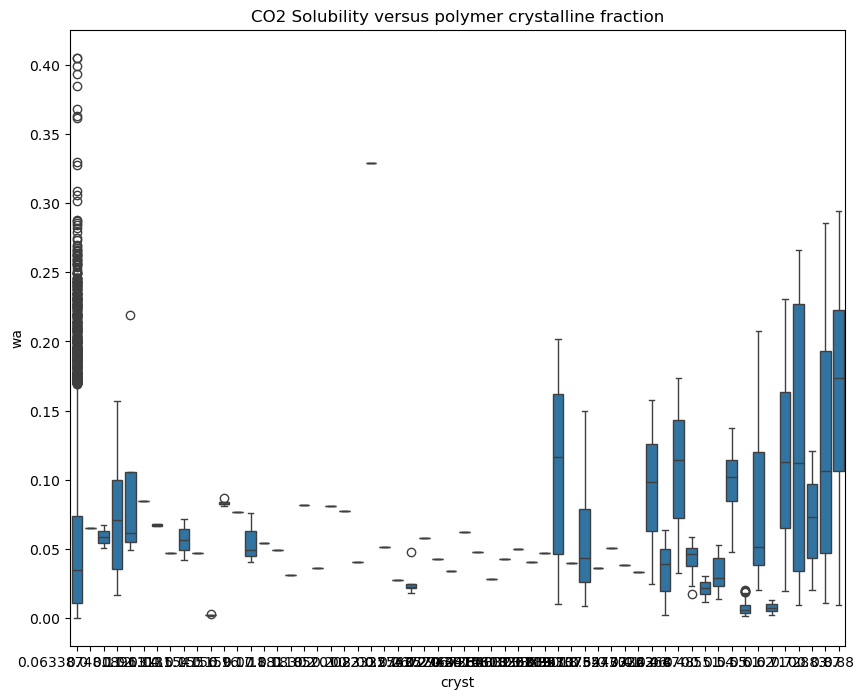

In [23]:
# Crystalline fraction
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_co2, x='cryst', y='wa')
ax.set_title('CO2 Solubility versus polymer crystalline fraction')
plt.show()

# Feature Engineering

In [30]:
features = ["temperature", "pressure", "dens", "tg", "mw", "mn", "cryst"]   # features to use
TARGET_COL = 'wa'  # target (solubility)
df_co2_f = df_co2[features + [TARGET_COL]]

num_cols = [c for c in df_co2_f.columns if df_co2[c].dtype != 'object' and c not in ['sol','pol', TARGET_COL]]
cat_cols = [c for c in df_co2_f.columns if df_co2[c].dtype == 'object']

preprocessor = ColumnTransformer([
    ('num', Pipeline([('scaler', StandardScaler())]), num_cols),
    ('cat', Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)])


In [32]:
cat_cols

[]

In [33]:
print("NaN counts in df_co2_f before splitting:")
print(df_co2_f.isnull().sum())

df_co2_f = df_co2_f.dropna()

NaN counts in df_co2_f before splitting:
temperature    0
pressure       0
dens           0
tg             0
mw             0
mn             0
cryst          0
wa             0
dtype: int64


# Data Split

Use 70% for training and 30% of dataset for testing:

In [34]:
train_val_df, test_df = train_test_split(df_co2_f, test_size=0.15, random_state=RANDOM_SEED) # 15% test set
train_df, val_df     = train_test_split(train_val_df, test_size=0.15, random_state=RANDOM_SEED) # 15% (of the remaining 85)% for validation set
print(len(train_df), len(val_df), len(test_df))

X_train, y_train = train_df.drop(columns=[TARGET_COL]), train_df[TARGET_COL]

4070 719 846


# Simple Models (Scikit-Learn and XGBoost)

### Linear Regression – baseline, interpretable

**Intuition**:
* Linear Regression tries to find the **single straight line **that best fits through these points.
* In cases with multiple input features (like temperature, pressure, density, etc.), it fits a **hyperplane** (a generalization of a line to higher dimensions) that best represents the linear relationship between all the input features and the single target variable (solubility).

**Parameters** (learned druing `.fit()`):
* `coef_`: These are the coefficients (or weights, slopes) calculated for each input feature in X_train. Each coefficient represents the estimated change in the target variable (y_train) for a one-unit increase in that specific feature, assuming all other features remain constant. The model learns these values from the data.
* `intercept_`: This is a single value representing the estimated value of the target variable when all input features are equal to zero. It's where the fitted line/hyperplane crosses the target variable's axis. This is also learned from the data.

**Hyperparameters** (Configured before `.fit()`):
* `fit_intercept` (boolean, default=True): Determines whether to calculate the intercept_. If set to False, the line/hyperplane is forced to pass through the origin (0,0). You might set this to False if you know from domain knowledge that the target must be zero when all inputs are zero.
* `positive` (boolean, default=False): If set to True, it forces the learned coef_ to be non-negative. This can be useful if you know from domain knowledge that the relationship between features and the target can only be positive or zero.

**In summary**: `LinearRegression` assumes a **linear relationship** and learns the optimal `coef_` and `intercept_` parameters from the data to minimize the squared errors. Hyperparameters like `fit_intercept` and `positive` allow you to impose constraints on this learning process based on prior assumptions about the model structure.

In [108]:
# Chain together the preprocessor and the model
# pipe_lr = Pipeline([('pre', preprocessor), ('lr', LinearRegression())]) # short version
# Define steps as a list of (name, estimator) tuples
steps = [
    ('scaler', StandardScaler()),  # First step: name 'scaler', object StandardScaler()
    ('model', LinearRegression()) # Second step: name 'model', object LinearRegression()
]

# Create the pipeline
pipe_lr = Pipeline(steps)

In [ ]:
# Linear Regression Model
# Use Negative RMSE. Because scikitlearn aims to maximise the score, so we need to negate it to get the RMSE.
lr_rmse = -cross_val_score(pipe_lr, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()   
print('LinearRegression CV RMSE:', lr_rmse)

LinearRegression CV RMSE: 0.039341222787276676


### Ridge Regression – shrink coefficients

* **Intuition**:
Ridge Regression is a **variation of Linear Regression**. Like standard Linear Regression, it aims to find a line (or hyperplane) that best fits the data by minimizing the sum of squared errors (RSS).

However, Ridge adds a **penalty** to this minimization process. The penalty is proportional to the sum of the squares of the coefficients (`coef_`). This is also known as **L2 regularization**.

Why add this penalty?

* **Reduces Model Complexity**: It discourages the model from learning overly large coefficients. Large coefficients can sometimes mean the model is fitting the noise in the training data too closely (**overfitting**) and might not generalize well to new, unseen data.
* **Handles Multicollinearity**: When input features are highly correlated, standard Linear Regression coefficients can become very large and unstable. Ridge helps to stabilize these coefficients.

Essentially, Ridge Regression tries to find a balance **between fitting** the training data well (low RSS) **and keeping the model simple** (small squared coefficients). It "shrinks" the coefficients towards zero, but unlike Lasso regression, it rarely makes them exactly zero.

**Parameters** (learned during `.fit()`):
* `coef_`: The coefficients (weights) learned for each feature. These are calculated by minimizing the objective function: RSS + alpha * sum(coef_**2). Due to the penalty term, these coefficients are **generally smaller in magnitude compared to those learned by standard LinearRegression**.
* `intercept_`: The intercept term, similar to LinearRegression. The intercept is typically **not included in the penalty term**.

**Hyperparameters** (configured before `.fit()`):
* `alpha` (float, non-negative, default=1.0): This is the **regularization strength parameter**. It controls how much weight is given to the penalty term (the sum of squared coefficients) versus the RSS.
    * If `alpha = 0`, the penalty term vanishes, and Ridge Regression becomes identical to standard Linear Regression.
    * As `alpha` increases, the penalty becomes stronger, forcing the coefficients to shrink more towards zero. This increases the model's bias but decreases its variance.
    * If `alpha` is very large, the coefficients will be shrunk very close to zero, potentially leading to **underfitting**.
* `fit_intercept` (boolean, default=True): Same as in LinearRegression, determines whether to calculate the intercept.
* `solver` (string, default='auto'): Specifies the numerical solver to use for the computation. Different solvers are more efficient depending on the data characteristics. `'auto'` usually selects the best one.

In [ ]:
for a in [0.01,0.1,1,10]:   # alpha values
    pipe_rr = Pipeline([('pre', preprocessor), ('ridge', Ridge(alpha=a))])
    score = -cross_val_score(pipe_rr, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    print(f'alpha={a}: {score:.4f}')

alpha=0.01: 0.0393
alpha=0.1: 0.0393
alpha=1: 0.0393
alpha=10: 0.0393


### k‑NN – non‑parametric

**Intuition**:

K-Nearest Neighbors (KNN) Regressor is a **non-parametric**, instance-based learning algorithm. Unlike linear models that try to learn a specific function (like a line or hyperplane) from the training data, KNN works differently:

1. **Memorization**: During the "training" phase (.fit()), KNN **simply stores** the entire training dataset (`X_train`, `y_train`). It **doesn't learn** explicit parameters like coefficients.
2. **Prediction**: When you want to predict the target value for a new, unseen data point:
    * It **calculates the distance** between this new point and every point in the stored training data using a chosen distance metric (usually Euclidean distance).
    * It identifies the 'k' training data points that are closest (the "nearest neighbors") to the new point.
    * It **predicts** the target value for the new point by taking the **average** (or weighted average) of the target values (`y_train`) of those 'k' nearest neighbors.

Essentially, KNN assumes that similar data points (in terms of their features) are likely to have similar target values. The prediction for a new point is based on the local neighborhood of points around it in the feature space.

**Parameters (learned during `.fit()`)**:
* `KNeighborsRegressor` is non-parametric, meaning it doesn't learn explicit parameters like `coef_` or `intercept_` in the way linear models do. The "learning" is simply storing the training data. The internal representation consists of the training data points (X_train) and their corresponding target values (y_train).

**Hyperparameters (configured before .fit())**:
* `n_neighbors` (int, default=5): This is the 'k' in K-Nearest Neighbors. It specifies how many nearest neighbors to consider when making a prediction.
    * A small k (e.g., 1 or 3) makes the model very sensitive to local variations and noise (high variance, low bias). The prediction boundary can be very jagged.
    * A large k makes the model smoother and less sensitive to noise, averaging over more points (low variance, high bias). If k is too large, it might over-smooth and miss local patterns.
* `weights` (str or callable, default='uniform'): Determines how the neighbors' target values are weighted when calculating the average.
    * `'uniform'`: All 'k' neighbors contribute equally to the average.
    * `'distance'`: **Closer neighbors have a stronger influence** on the average than farther neighbors. The weight is typically the inverse of the distance.
* `metric` (str or callable, default='minkowski'): The distance metric used to find the nearest neighbors. With the default `p=2`, `'minkowski'` is equivalent to the **standard Euclidean distance**. Other metrics like 'manhattan' (p=1) can also be used.
* `p` (int, default=2): Power parameter for the Minkowski metric. `p=1` is Manhattan distance, `p=`2 is Euclidean distance.

In [111]:
for k in [3,5,10,20]:   # k values
    score = -cross_val_score(Pipeline([('pre', preprocessor), ('knn', KNeighborsRegressor(n_neighbors=k))]),
                              X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    print(f'k={k}: {score:.4f}')

k=3: 0.0154
k=5: 0.0175
k=10: 0.0228
k=20: 0.0270


### Decision Tree – capturing non‑linear splits

**Intuition**:

A Decision Tree Regressor builds a model in the form of a tree structure to predict a continuous target variable. It works by recursively partitioning the data based on feature values:

1. **Splitting**: It starts with the entire dataset (root node) and finds the best feature and the best threshold value for that feature to split the data into two subsets (child nodes). The "best" split is typically the one that **minimizes the impurity** (variance or mean squared error) within the resulting subsets. For regression, common criteria are Mean Squared Error (MSE) or Mean Absolute Error (MAE).
2. **Recursion**: This splitting process is repeated for each child node, using the subset of data within that node. It continues until a **stopping condition** is met.
3. **Prediction**: To predict the target value for a new data point, the point traverses the tree from the root down. At each node, it follows the branch corresponding to its feature values. When it reaches a leaf node (a node that doesn't split further), the prediction is typically the average of the target values (`y_train`) of all the training data points that ended up in that same leaf node during training.

Decision trees can naturally capture **non-linear relationships** between features and the target variable by creating **complex, nested rules**.

**Parameters (learned during `.fit()`)**:
* The model doesn't learn explicit coefficients like linear models. Instead, it learns the structure of the tree:
    * Which feature is used for splitting at each internal node.
    * The threshold value used for the split at each internal node.
    * The predicted value (usually the mean of the samples) associated with each leaf node.

**Hyperparameters (configured before `.fit()`)**:

Decision trees have several hyperparameters to control their complexity and prevent overfitting:
* `max_depth` (int, default=None): The **maximum depth** allowed for the tree. Depth is the length of the longest path from the root node to a leaf node.
    * If `None`, nodes are expanded **until all leaves are pure** (**contain samples with very similar target values**) or until they contain fewer samples than `min_samples_split`.
    * A smaller `max_depth` restricts the tree's complexity, making it **less prone to overfitting** but potentially increasing bias (underfitting) if it's too small to capture the data's patterns.
    * A larger `max_depth` allows the tree to model more complex relationships but increases the **risk of overfitting** the training data.
* criterion ({"squared_error", "friedman_mse", "absolute_error", "poisson"}, default="squared_error"): The function used to measure the quality of a split. `"squared_error"` (MSE) is common for regression.
* `min_samples_split` (int or float, default=2): The **minimum number of samples required to split **an internal node. Helps prevent splits on nodes with very few samples.
* `min_samples_leaf` (int or float, default=1): The minimum number of samples required to be at a leaf node. Ensures that leaves have a minimum size, smoothing the model.

In [112]:
for depth in [None,5,10,20]:
    score = -cross_val_score(Pipeline([('pre', preprocessor), ('dt', DecisionTreeRegressor(max_depth=depth))]),
                              X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    print(f'depth={depth}: {score:.4f}')

depth=None: 0.0164
depth=5: 0.0289
depth=10: 0.0184
depth=20: 0.0165


## Random Forest – ensemble reduces variance

**Intuition**:

Random Forest is an ensemble learning method based on decision trees. Instead of relying on a single decision tree (which can be prone to overfitting), a Random Forest builds **many decision trees** during training and outputs the average of their predictions for regression tasks.

Here's how it achieves this and why it's effective:
1. **Bagging** (Bootstrap Aggregating): Each individual decision tree in the forest is trained on a **different random subset** of the original training data. These subsets are created using "bootstrapping," which means sampling the original data with replacement. So, **some data points might appear multiple times** in a subset, while others might not appear at all.
2. **Feature Randomness**: When splitting a node during the construction of each individual tree, the split is chosen not from all features, but from a **random subset of the features**. This introduces more diversity among the trees.
3. **Averaging Predictions**: To make a prediction for a new data point, the point is passed down through all the trees in the forest. Each tree makes its own prediction. The final prediction of the Random Forest is the **average of the predictions from all the individual trees**.

This combination of bagging and feature randomness creates a collection of diverse trees. By averaging their predictions, the Random Forest **reduces the variance (overfitting)** typically associated with individual decision trees, leading to a more robust and accurate model that generalizes better to unseen data.

**Parameters (learned during `.fit()`)**:
* Similar to a single decision tree, a Random Forest doesn't learn explicit coefficients. Instead, it learns the **structure of each individual decision tree within the ensemble** (the splits, thresholds, and leaf values for all trees).

**Hyperparameters (Configured before `.fit()`)**:
* `n_estimators` (int, default=100): The number of decision trees to build in the forest.
    * More trees generally lead to better performance and smoother predictions, but also increase training time and model size. Performance often plateaus after a certain number of trees. In your code, it's set to 300.
* `max_depth` (int, default=None): The maximum depth allowed for each individual tree (same as in DecisionTreeRegressor). Controls the complexity of individual trees. Deeper trees can capture more complex patterns but risk overfitting.
* `min_samples_split` (int or float, default=2): The minimum number of samples required to split an internal node in each tree.
* `min_samples_leaf` (int or float, default=1): The minimum number of samples required to be at a leaf node in each tree.
* `max_features` ({int, float, "sqrt", "log2"}, default="sqrt"): The **number (or fraction) of features to consider when looking for the best split** at each node in each tree. **Introducing randomness** here helps decorrelate the trees.
    * `"sqrt"` (used by default for regression in scikit-learn prior to version 1.1, now it's 1.0 or all features) means max_features=sqrt(n_features).
    * `"log2"` means `max_features=log2(n_features)`.
    * Setting it to `1.0` or `None` means all features are considered (`max_features=n_features`).
* `n_jobs` (int, default=None): The number of CPU cores to use for training and prediction.
    * `n_jobs=-1` typically means use all available cores, which can significantly speed up the process as trees can be built in parallel. This is used in your code.
* `random_state` (int, RandomState instance or None, default=None): Controls the randomness involved in bootstrapping the samples (bootstrap=True) and selecting features for splits (`max_features < n_features`).
    * Setting it to a specific integer (like `RANDOM_SEED`) ensures that the results are reproducible. If you run the code again with the same `random_state`, you will get the exact same forest and results.

In [113]:
rf = Pipeline([('pre', preprocessor), ('rf', RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=RANDOM_SEED))])
rf_rmse = -cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
print('RandomForest CV RMSE:', rf_rmse)


RandomForest CV RMSE: 0.012014148755924844


## Gradient Boosting – sequential error correction

**Intuition**:

Gradient Boosting is another powerful ensemble learning technique that builds models (typically decision trees) in a **sequential** manner. Unlike Random Forest which builds trees independently and in parallel, Gradient Boosting builds trees one after another, with **each new tree trying to correct the errors made by the previously built ensemble**.

Here's the core idea:
1. **Initial Model**: It starts with a simple initial model, often just the mean of the target variable (y_train).
2. **Calculate Residuals**: It calculates the errors (residuals) made by the current ensemble model on the training data (the difference between the actual y_train and the ensemble's predictions).
3. **Fit New Tree to Residuals**: It trains a new, usually shallow, decision tree (a **"weak learner"**) to predict these residuals. The goal of this tree is to capture the patterns in the errors that the current ensemble is making.
4. **Update Ensemble**: The predictions of this new tree are added to the ensemble's predictions, scaled by a learning rate. This update aims to reduce the overall error.
5. **Repeat**: Steps 2-4 are repeated for a specified number of iterations (`n_estimators`), with each new tree focusing on the remaining errors of the updated ensemble.

The final prediction for a new data point is the sum of the predictions from the initial model and all the sequentially added trees (each scaled by the learning rate). By iteratively focusing on the errors, Gradient Boosting can build highly accurate models.

**Parameters (learned during `.fit()`)**:
* Similar to other tree-based ensembles, Gradient Boosting doesn't learn explicit coefficients. It learns the sequence of weak learners (trees) and how much each tree contributes to the final prediction (implicitly determined by the fitting process and the learning rate).

**Hyperparameters (configured before `.fit()`)**:
* `n_estimators` (int, default=100): The total number of sequential trees (boosting stages) to be performed.
    * More estimators generally lead to better performance on the training data, but too many can lead to overfitting. In your code, it's set to 500.
* `learning_rate` (float, default=0.1): This parameter scales the contribution of each tree.
    * It shrinks the contribution of each tree by the `learning_rate`. 
    * There is a **trade-off** between `learning_rate` and `n_estimators`: **lower learning rates generally require more estimators** for the same performance but often lead to better generalization (less overfitting). In your code, it's set to 0.05, which is a relatively small value, often paired with a higher n_estimators.
* `max_depth` (int, default=3): The maximum depth of the individual regression estimators (the weak learners/trees).
    * Constraining the` max_depth` (e.g., to 3, 5) is crucial for **preventing overfitting** in Gradient Boosting, as each tree is only meant to capture a part of the overall pattern. Deep trees are generally avoided.
* `subsample` (float, default=1.0): The fraction of samples to be used for **fitting the individual base learners**.
    * If **less than 1.0**, this results in **Stochastic Gradient Boosting**. It introduces **randomness**, can reduce variance, and speed up training, potentially preventing overfitting.
* `loss` ({"squared_error", "absolute_error", "huber", "quantile"}, default="squared_error"): The loss function to be optimized. `"squared_error"` corresponds to standard regression.

In [114]:
gb = Pipeline([('pre', preprocessor), ('gb', GradientBoostingRegressor(n_estimators=500, learning_rate=0.05))])
gb_rmse = -cross_val_score(gb, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
print('GradientBoosting CV RMSE:', gb_rmse)

GradientBoosting CV RMSE: 0.012950097403721508


## Support Vector Regression – kernel trick

**Intuition**:

Support Vector Regression (SVR) is a **type of Support Vector Machine (SVM)** adapted for **regression** problems (predicting continuous values). Unlike standard linear regression which tries to minimize the error for all points, SVR tries to fit a line (or hyperplane) such that as many data points as possible lie within a certain margin around that line.
1. **Margin of Tolerance (Epsilon-Insensitive Tube)**: SVR defines a "tube" around the regression line with a width determined by the hyperparameter epsilon (**ε**). Errors for data points falling inside this tube are ignored in the loss function.
2. **Minimizing Error Outside the Tube**: For points falling outside the tube, SVR tries to minimize their distance to the edge of the tube (not necessarily the regression line itself).
3. **Support Vectors**: The data points that lie exactly on the boundary of the tube or outside it are called **support vectors**. These are the critical points that define the position and orientation of the regression line and the tube. Points inside the tube do not influence the model.
4. Kernel Trick (for Non-linearity): Similar to SVMs for classification, SVR can handle **non-linear relationships using the kernel trick**. Kernels (like 'linear', 'poly', 'rbf') implicitly transform the data into a higher-dimensional space where a linear separation (or a linear regression within the epsilon-tube) might be possible.
    * `'linear'`: Fits a standard linear SVR.
    * `'rbf'` (Radial Basis Function): Can capture complex, non-linear patterns by considering local similarity between points.

SVR aims to find a function that deviates from the actual target values (`y_train`) by a value no greater than epsilon for as many training points as possible, while also being as "flat" as possible (controlled by regularization parameter C).

**Parameters (learned during `.fit()`)**:
* `support_vectors_`: The subset of training data points that are the support vectors.
* `dual_coef_`: Coefficients associated with the support vectors in the dual problem formulation. These determine the **contribution of each support vector** to the final decision function.
* `intercept_`: The constant term in the decision function (similar to the intercept in linear models).

**Hyperparameters (configured before `.fit()`):**
* `kernel` (str, default='rbf'): Specifies the type of kernel to be used in the algorithm. Common choices include:
    * `'linear'`: For linear relationships.
    * `'poly'`: Polynomial kernel.
    * `'rbf'`: Radial Basis Function (Gaussian) kernel, good for non-linear relationships.
    * `'sigmoid'`: Sigmoid kernel.
* `C` (float, default=1.0): The regularization parameter. It controls the **trade-off between achieving a low error on the training data and minimizing the model complexity** (keeping the margin wide or the function flat).
    * A **large `C`** (like C=5 in your code) means the model tries harder to fit the training data well, potentially leading to a narrower margin and **overfitting** if points outside the epsilon-tube are heavily penalized.
    * A **small `C`** allows for more errors (points outside the tube) in exchange for a potentially **simpler/flatter model** (wider margin).
* `epsilon` (float, default=0.1): Defines the width of the epsilon-insensitive tube. No penalty is associated with training points whose predictions fall within this distance (epsilon) of their actual target value.
    * A arger `epsilon` means a wider tube, allowing more tolerance for errors and potentially leading to a simpler model with fewer support vectors.
    * A smaller `epsilon` means a narrower tube, making the model more sensitive to errors.
* `gamma` (float or {'scale', 'auto'}, default='scale'): Kernel **coefficient** for 'rbf', 'poly', and 'sigmoid'. It defines how much influence a single training example has. Higher gamma means closer points have more influence (can lead to **overfitting**). `'scale'` (default) uses `1 / (n_features * X.var())`.

In [35]:
for k in ['linear','rbf']:  # kernel types
    # Create the SVR model with the specified kernel
    svr = SVR(kernel=k, C=5, epsilon=0.1)
    
    # Create the pipeline with the preprocessor and the SVR model
    score = -cross_val_score(Pipeline([('pre', preprocessor), ('svr', svr)]),
                              X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    print(f'SVR-{k}: {score:.4f}')

SVR-linear: 0.0583
SVR-rbf: 0.0462


## XGBoost – powerful boosting with regularisation

**Intuition**:

XGBoost (Extreme Gradient Boosting) is an optimized and enhanced implementation of the Gradient Boosting algorithm. Like standard Gradient Boosting, it **builds decision trees sequentially**, with each new tree **attempting to correct the errors made by the previous ensemble**.

However, XGBoost incorporates several key improvements:
1. **Regularization**: XGBoost includes both **L1 (Lasso) and L2 (Ridge) regularization** terms in its objective function during training. This helps to **prevent overfitting** by penalizing complex models (e.g., trees with large leaf weights).
2. **Advanced Tree Building**: It uses a **more sophisticated approach to finding the best splits when building trees**, considering the objective function (including regularization) directly. It also handles missing values internally.
3. **Hardware Optimization**: XGBoost is designed for efficiency and speed. It supports parallel processing (`n_jobs`), cache-aware access, and other optimizations to make training faster, especially on large datasets.
4. **Subsampling**: Like Stochastic Gradient Boosting, XGBoost allows for subsampling of both rows (subsample) and columns (`colsample_bytree`) when building each tree, further reducing variance and preventing overfitting.

In essence, XGBoost takes the **core idea of Gradient Boosting** (sequential error correction) and **adds regularization** and various **computational optimizations** to create a highly efficient, flexible, and often state-of-the-art algorithm for many regression (and classification) tasks.

**Parameters (learned during `.fit()`)**:
* Similar to Gradient Boosting, XGBoost learns the sequence of decision trees, including their structure (splits, thresholds) and the values assigned to the leaf nodes of each tree. The regularization terms influence these learned values.

**Hyperparameters (configured before `.fit()`)**:
* `n_estimators` (int, default=100): The number of boosting rounds or sequential trees to build.
    * Similar to Gradient Boosting, more trees can improve accuracy but increase the risk of overfitting and training time. In your code, it's set to 800.
* `max_depth` (int, default=6): The maximum depth of each individual tree (weak learner).
    * Controls the complexity of individual trees. **Deeper trees can capture more interactions but are more prone to overfitting**. 6 is a moderately deep setting for XGBoost.
* `learning_rate` (float, alias: eta, default=0.3): Step size shrinkage used in updates to prevent overfitting. It scales the **contribution of each new tree**.
    * Lower values (like 0.05 in your code) make the boosting process more conservative, usually requiring more **n_estimators** but often leading to better generalization.
* `subsample` (float, default=1.0): The fraction of training samples used to build each tree.
    * Setting it **below 1.0** introduces **randomness** (**stochastic gradient boosting**), helps prevent overfitting, and can speed up training.
* `colsample_bytree` (float, default=1.0): The fraction of features (columns) used when constructing each tree.
    * Setting it **below 1.0** adds another layer of **randomness**, further reducing overfitting.
* `objective` (string or callable, default='reg:squarederror'): Specifies the learning task and the corresponding objective function.
    * `'reg:squarederror'` indicates regression with squared error loss, which is standard for regression problems aiming to minimize RMSE.
* `random_state` (int, alias: seed, default=None): Controls the random number generator used for subsampling rows and columns.
    * Setting it to a specific integer ensures reproducibility of the results when subsampling is active.
* `n_jobs` (int, default=None): The number of parallel threads used for running XGBoost.
    * Setting it to **-1** typically means using **all available CPU cores**, significantly speeding up the training process.
* `reg_alpha` (float, alias: alpha, default=0): **L1 regularization term** on weights.
* `reg_lambda` (float, alias: lambda, default=1): **L2 regularization** term on weights. (Note: XGBoost's default L2 is 1, unlike scikit-learn's GradientBoostingRegressor).

In [2]:
xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.05, subsample=0.8,
                  colsample_bytree=0.8, objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
pipe_xgb = Pipeline([('pre', preprocessor), ('xgb', xgb)])
xgb_rmse = -cross_val_score(pipe_xgb, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, error_score='raise').mean()
print('XGBoost CV RMSE:', xgb_rmse)


NameError: name 'preprocessor' is not defined

## Neural Network

## Define model

In [24]:
reg = xgb.XGBRegressor(base_score=0.5, booster="gbtree", 
                       n_estimators=1000, # number of parallel trees
                       early_stopping_rounds=50, # stop after 50 iterations if no improvement                       
                       max_depth=3, # tree depth
                       learning_rate=0.01,)

reg.fit(train_X, train_Y,
       eval_set=[(train_X, train_Y), (test_X, test_Y)],
       verbose=100 # report every 100 steps
       )


[0]	validation_0-rmse:0.43987	validation_1-rmse:0.44015
[100]	validation_0-rmse:0.16379	validation_1-rmse:0.16416
[200]	validation_0-rmse:0.06453	validation_1-rmse:0.06525
[300]	validation_0-rmse:0.03138	validation_1-rmse:0.03270
[400]	validation_0-rmse:0.02180	validation_1-rmse:0.02362
[500]	validation_0-rmse:0.01882	validation_1-rmse:0.02060
[600]	validation_0-rmse:0.01742	validation_1-rmse:0.01924
[700]	validation_0-rmse:0.01649	validation_1-rmse:0.01837
[800]	validation_0-rmse:0.01567	validation_1-rmse:0.01762
[900]	validation_0-rmse:0.01502	validation_1-rmse:0.01704
[999]	validation_0-rmse:0.01454	validation_1-rmse:0.01656


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature importance

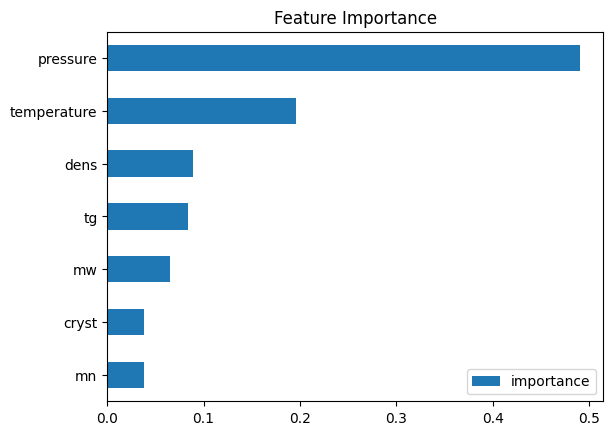

In [25]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Score on Test set (RMSE and normalised RMSE)

In [26]:
wa_prediction = reg.predict(test_X)
RMSE_score = np.sqrt(mean_squared_error(test_Y, wa_prediction))
nRMSE_score = RMSE_score / np.std(test_Y)
print(f'RMSE Score on Test set: {RMSE_score:0.2f}')
print(f'nRMSE Score on Test set: {nRMSE_score:0.2f}')

RMSE Score on Test set: 0.02
nRMSE Score on Test set: 0.25


# Neural Network (PyTorch)

### Simple NN

### Complex NN

## Combination of Models

# MLOps Pipeline